## Explainer notebook

**Motivation**

* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user’s experience?

This project concerns itself with our derived dataset containing artists from pop and rap culture within North America. As music plays a significant role for most peoples lives including our’s it was naturally intriguing for us to delve down the path of music as soon as it was an option. Ideas sparked, and the question `Do rap and pop culture collaborate differently? If so, how?` served as a catalyst for our exploration.

We wanted to figure out how the structures in the networks of rap and pop are constructed and differ. What makes a community within rap and pop. Do rap and pop communities differ and what does that say about culture?

Wee initially found a dataset containing ~156.000 artists and ~300.000 discovered collaborators between artist A and B, i.e. artist A and B has produced at least one song together. The choice of network graph was natural from this point as artists are naturally nodes and edges are 1 if artist A and B worked together 0 if they have not. However, this dataset contained artists from all over the world and of any size. Therefore we derived a subset, which is further explained in the data section, that contains only relevant artists in North America within rap and pop genres. From here we could dive in and do our analysis.



Large dataset:

`https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR5jxk4FClm9GBFvCklV4Ga5SRwON3ajfqLdOMjFqN1uereEEduffCtjEbkjJg_aem_YUf8t7fIjwbCWiHS_vrVc`

Top 10k most listened us artists dataset:

`https://www.kaggle.com/datasets/spoorthiuk/us-top-10k-artists-and-their-popular-songs`

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict
import netwulf as nw
import numpy as np
import re
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0 
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from scipy.stats import chi2
from nltk.tokenize import MWETokenizer
from wordcloud import WordCloud
import math
import pickle 

## Loading the datasets

In [2]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')
nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
nodes_df

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"[nordic house, russelater]",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"[christlicher rap, german hip hop]","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,[],['de (1)']
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"[dancehall, lovers rock, modern reggae, reggae...","['at (1)', 'de (1)']"
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"[classic swedish pop, norrbotten indie, swedis...",['se (6)']
...,...,...,...,...,...,...
156417,2ces6d2YsQP1RpGMYpdFy8,David Urwitz,5470.0,29,[classic swedish pop],NaN
156418,6AeznZajNbXUulT7W4tK5l,Darmiko,2022.0,23,[],NaN
156419,3GEijIjrgb4lPe9WtURBzz,Katriell,268.0,0,[],NaN
156420,0ldQL0icSoMz9OOZcWG8Zt,Yung Fresh,181.0,19,[],NaN


In [3]:
artists_us_df = pd.read_csv("most_listened_artists_in_US_dataset.csv", index_col=0)
artists_us_df

,ID,Gender,Age,Country,Genres,Popularity,Followers,URI
Name,,,,,,,,
Drake,3TVXtAsR1Inumwj472S9r4,male,33,CA,"['canadian hip hop', 'canadian pop', 'hip hop'...",95,83298497,spotify:artist:3TVXtAsR1Inumwj472S9r4
Post Malone,246dkjvS1zLTtiykXe5h60,male,25,US,"['dfw rap', 'melodic rap', 'pop', 'rap']",86,43130108,spotify:artist:246dkjvS1zLTtiykXe5h60
Ed Sheeran,6eUKZXaKkcviH0Ku9w2n3V,male,29,GB,"['pop', 'singer-songwriter pop', 'uk pop']",87,115998928,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V
J Balvin,1vyhD5VmyZ7KMfW5gqLgo5,male,35,CO,"['reggaeton', 'reggaeton colombiano', 'trap la...",83,38028010,spotify:artist:1vyhD5VmyZ7KMfW5gqLgo5
Bad Bunny,4q3ewBCX7sLwd24euuV69X,male,26,PR,"['reggaeton', 'trap latino', 'urbano latino']",95,77931484,spotify:artist:4q3ewBCX7sLwd24euuV69X
...,...,...,...,...,...,...,...,...
IVAN$ITO,0cPmSFfjpop7imPVWSk2yc,NaN,0,NaN,[],20,4249,spotify:artist:0cPmSFfjpop7imPVWSk2yc
Antonello Venditti,3hYLJPJuDyblFKersEaFd6,male,71,IT,"[""canzone d'autore"", 'classic italian pop', 'i...",54,778642,spotify:artist:3hYLJPJuDyblFKersEaFd6
Lea Salonga,1GlMjIezcLwV3OFlX0uXOv,female,49,PH,"['movie tunes', 'tagalog worship']",56,179832,spotify:artist:1GlMjIezcLwV3OFlX0uXOv


In [4]:
artists_us_name_list = (artists_us_df.index).tolist()
print(artists_us_name_list[:5])

['Drake', 'Post Malone', 'Ed Sheeran', 'J Balvin', 'Bad Bunny']


## Finding the intersection betwen the two datasets

We will now be constructing our dataset as a intersection between the large spotify collaration dataset and `artists_us_name_list`

In [5]:
nodes_df = nodes_df[nodes_df["name"].isin(artists_us_name_list)]
nodes_df

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"[nordic house, russelater]",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"[christlicher rap, german hip hop]","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
15,3xs0LEzcPXtgNfMNcHzLIP,Rockwell,40344.0,58,[],"['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (..."
20,2NUz5P42WqkxilbI8ocN76,Vybz Kartel,1026598.0,63,"[dancehall, jamaican dancehall, reggae fusion]","['cr (3)', 'pa (1)']"
22,4Lm0pUvmisUHMdoky5ch2I,Apocalyptica,864846.0,60,"[alternative metal, bow pop, cello, finnish me...",['fi (2)']
...,...,...,...,...,...,...
156038,7p5J8SfKU9Rulp7tcA53G8,Jose Merce,182186.0,51,"[cante flamenco, flamenco, nuevo flamenco, rumba]",NaN
156119,3gJ0f9ov2Vjrbo9RnFFH76,Endor,267.0,2,[scottish indie folk],NaN
156199,7mKmqnXqn1WoEFljKyvAHR,2T FLOW,20.0,29,[],NaN
156220,6kT18gnkVrCz8xJQcrib7L,Bhaskar,230894.0,60,"[brazilian bass, brazilian edm, brazilian house]",NaN


By inspecting the dataframe, we notice there are more artists in the intersection than in the dataset containing the most listened artists in the US. This indicates there are duplicates in the dataset. We will inspect this:

In [6]:
duplicate_names = nodes_df[nodes_df.duplicated(subset="name", keep=False)].sort_values(by="name")

duplicate_names

,spotify_id,name,followers,popularity,genres,chart_hits
43592,1ItNxpDdetHb2gyS10HKfF,18 Karat,1644.0,18,[],NaN
13282,5oWFxbBrbk2Mw86PLUg3OZ,18 Karat,292544.0,53,"[deep german hip hop, german hip hop, german u...","['at (16)', 'de (30)', 'lu (3)', 'ch (12)']"
57139,09ZUMxxU5pgzUF0FtHeGXG,19HUNNID,5.0,1,[],NaN
59493,2Zm4abMQXwcrsM9IWY3AoB,19HUNNID,513.0,31,[thai trap],NaN
156199,7mKmqnXqn1WoEFljKyvAHR,2T FLOW,20.0,29,[],NaN
...,...,...,...,...,...,...
146823,1wEQjEpK6KfE9Et2ZZBfPa,Żabson,43.0,4,[],NaN
24780,0FtUnl4AjR5eDa1v77WU0b,ปู่จ๋าน ลองไมค์,138.0,17,[],NaN
95174,23YWwPEvaO5HLqEMgiUXJa,ปู่จ๋าน ลองไมค์,23424.0,32,[],NaN
6081,3dTgjg7lzUGiD3NwcGCK1n,阿冗,44494.0,48,"[chinese viral pop, mainland chinese pop]","['my (1)', 'sg (1)', 'tw (4)']"


As we can see, there are a large number of duplicate names. This is likely due to the size of the Spotify dataset, which contains more than 156,000 artists. It is also a consequence of spotify names which are not unique, meaning many small and  negligible artists are included in our dataframe. 

For example on spotify, consider the user `Drake`  who is in the top 10.000. Since the spotify names are not unique some negligible small spotify user could use the `Drake` name aswell and be included in our filtering process. To address this, we will apply a simple algorithm: for duplicate names, we will keep only the artist with the most Spotify followers.

In [7]:
final_cleaned_nodes_df = nodes_df.sort_values("followers", ascending=False)
final_cleaned_nodes_df = nodes_df.drop_duplicates(subset="name", keep="first")
final_cleaned_nodes_df

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"[nordic house, russelater]",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"[christlicher rap, german hip hop]","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
15,3xs0LEzcPXtgNfMNcHzLIP,Rockwell,40344.0,58,[],"['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (..."
20,2NUz5P42WqkxilbI8ocN76,Vybz Kartel,1026598.0,63,"[dancehall, jamaican dancehall, reggae fusion]","['cr (3)', 'pa (1)']"
22,4Lm0pUvmisUHMdoky5ch2I,Apocalyptica,864846.0,60,"[alternative metal, bow pop, cello, finnish me...",['fi (2)']
...,...,...,...,...,...,...
155870,3a9qv6NLHnsVxJUtKOMHvD,The Glitch Mob,538974.0,61,"[edm, electro house, glitch, glitch hop, indie...",NaN
156036,7dh6G6qILmRpUtZU4ZSD4D,Trobeats,515.0,9,[],NaN
156038,7p5J8SfKU9Rulp7tcA53G8,Jose Merce,182186.0,51,"[cante flamenco, flamenco, nuevo flamenco, rumba]",NaN
156220,6kT18gnkVrCz8xJQcrib7L,Bhaskar,230894.0,60,"[brazilian bass, brazilian edm, brazilian house]",NaN


Now, as we can see the intersection contains only 8756 rows (before 9754), meaning we succesfully removed 998 duplicate artists with the least amount of followers. We have now reached our final desired dataset

## Functions for constructing the desired networks:

In [8]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
        
        filtered_dfs.append(df)

    return filtered_dfs

def get_Graph_with_names(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Build ID to name map
    id_to_name = dict(zip(nodes_df['spotify_id'], nodes_df['name']))
    allowed_ids = set(id_to_name.keys())

    # Create graph with artist names as nodes
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        artist_name = row['name']
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []

        G.add_node(artist_name, followers=followers, popularity=popularity,
                   genres=genres, chart_hits=chart_hits)

    for _, row in edges_df.iterrows():
        id_0, id_1 = row['id_0'], row['id_1']
        if id_0 in allowed_ids and id_1 in allowed_ids:
            name_0 = id_to_name.get(id_0)
            name_1 = id_to_name.get(id_1)
            if name_0 and name_1:
                G.add_edge(name_0, name_1)

    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
    
    communities = defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    return sorted_communities
        
def get_community_subgraph(G, community_id):
    nodes_in_community = [n for n, attr in G.nodes(data=True) if attr.get('community') == community_id]
    
    subgraph = G.subgraph(nodes_in_community).copy()
    
    return subgraph

def get_combined_louvain_splitted_graph(G):
    _G = G.copy()
    partition = community_louvain.best_partition(_G)
    nx.set_node_attributes(_G, partition, 'community')

    combined_G = nx.Graph()
    
    combined_G.add_nodes_from(_G.nodes(data=True))

    for u, v in _G.edges():
        if partition[u] == partition[v]:
            combined_G.add_edge(u, v, **_G[u][v])

    return combined_G

def print_top_collaborators(G, n):
    top_collaborators = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]

    print(f"Top {n} artists with the most collaborations:")
    for rank, (artist, degree) in enumerate(top_collaborators, start=1):
        print(f"{rank}. {artist} — {degree} collaborations")


In [9]:
pop_df, rap_df = split_artists_by_genre(final_cleaned_nodes_df, ["pop", "rap"])

len(pop_df), len(rap_df)

(4398, 1704)

In [11]:
print("---- Large Pop network: ----")
G_pop = get_Graph_with_names(pop_df, edges_df)
print("\n---- Large Rap network: ----")
G_rap = get_Graph_with_names(rap_df, edges_df)

---- Large Pop network: ----
Number of nodes: 4398
Number of edges: 17648
Network density: 0.0018252140370625595

---- Large Rap network: ----
Number of nodes: 1704
Number of edges: 11704
Network density: 0.008066405873093326


In [12]:
print_top_collaborators(G_rap, 5)

Top 5 artists with the most collaborations:
1. Ty Dolla $ign — 133 collaborations
2. Gucci Mane — 128 collaborations
3. French Montana — 124 collaborations
4. Future — 116 collaborations
5. Lil Wayne — 113 collaborations


In [14]:
print(print_top_collaborators(G_pop, 5))

Top 5 artists with the most collaborations:
1. R3HAB — 165 collaborations
2. Ty Dolla $ign — 141 collaborations
3. David Guetta — 135 collaborations
4. Snoop Dogg — 123 collaborations
5. Steve Aoki — 117 collaborations
None


In [16]:
G_rap_splittet = get_combined_louvain_splitted_graph(G_rap)

In [17]:
communities = apply_louvain(G_rap)
largest_community_id = communities[0][0]

G_largest_rap_community = get_community_subgraph(G_rap, largest_community_id)
G_largest_rap_community_splitted = get_combined_louvain_splitted_graph(G_largest_rap_community)

Community 2: 448 nodes
Community 5: 258 nodes
Community 1: 141 nodes
Community 14: 130 nodes
Community 11: 122 nodes
Community 9: 98 nodes
Community 27: 92 nodes
Community 16: 65 nodes
Community 7: 56 nodes
Community 67: 27 nodes
Community 21: 26 nodes
Community 22: 20 nodes
Community 4: 18 nodes
Community 35: 17 nodes
Community 12: 5 nodes
Community 54: 5 nodes
Community 83: 4 nodes
Community 119: 4 nodes
Community 31: 3 nodes
Community 42: 3 nodes
Community 113: 3 nodes
Community 149: 3 nodes
Community 47: 2 nodes
Community 90: 2 nodes
Community 91: 2 nodes
Community 112: 2 nodes
Community 123: 2 nodes
Community 3: 1 nodes
Community 6: 1 nodes
Community 10: 1 nodes
Community 13: 1 nodes
Community 15: 1 nodes
Community 17: 1 nodes
Community 18: 1 nodes
Community 20: 1 nodes
Community 24: 1 nodes
Community 25: 1 nodes
Community 26: 1 nodes
Community 28: 1 nodes
Community 29: 1 nodes
Community 30: 1 nodes
Community 32: 1 nodes
Community 33: 1 nodes
Community 34: 1 nodes
Community 36: 1 

## Visualzing the networks with `Netwulf`

In [21]:
# Visualize pop network

from Netwulf_plot_functions import netwulf_plot_communities
from community import community_louvain 

communities = community_louvain.best_partition(G_pop)

colors = ['#e57468', '#68e574', '#7468e5', '#e5d068', '#68d0e5']

netwulf_plot_communities(G_pop, communities, port=9981, color_palette=colors, path="Pop_network.pdf")

tmpgraph.json


TypeError: 'NoneType' object is not subscriptable

In [23]:
# Visualize rap network

from Netwulf_plot_functions import netwulf_plot_communities
from community import community_louvain 

communities = community_louvain.best_partition(G_rap)

colors = ['#e57468', '#68e574', '#7468e5', '#e5d068', '#68d0e5']

netwulf_plot_communities(G_rap, communities, port=9981, color_palette=colors, path="Rap_network.pdf")

tmpgraph.json


TypeError: 'NoneType' object is not subscriptable

## Network key statistics

In [24]:
from Network_statistics import print_network_statistics

In [25]:
print_network_statistics(G_pop)

Pop network statistics

Number of nodes: 4398
Number of edges: 17648
Density: 0.0018252140370625595
Number of isolated nodes: 736
Is connected: False
Number of connected components: 776
Size of largest component: 3551
Average shortest path length (largest component): 5.056972802741541
Average clustering coefficient: 0.14299548786390026
Transitivity (global clustering coefficient): 0.17630606849249938

Degree analysis
Average Degree: 8.03
Median Degree: 4.0
Mode Degree: 0
Minimum Degree: 0
Maximum Degree: 165


In [26]:
print_network_statistics(G_rap)

Pop network statistics

Number of nodes: 1704
Number of edges: 11704
Density: 0.008066405873093326
Number of isolated nodes: 146
Is connected: False
Number of connected components: 159
Size of largest component: 1500
Average shortest path length (largest component): 4.242214809873249
Average clustering coefficient: 0.26984041262185426
Transitivity (global clustering coefficient): 0.2903691218607787

Degree analysis
Average Degree: 13.74
Median Degree: 7.0
Mode Degree: 1
Minimum Degree: 0
Maximum Degree: 133


## Plotting degree distributions

In [27]:
from Network_statistics import plot_degree_distribution

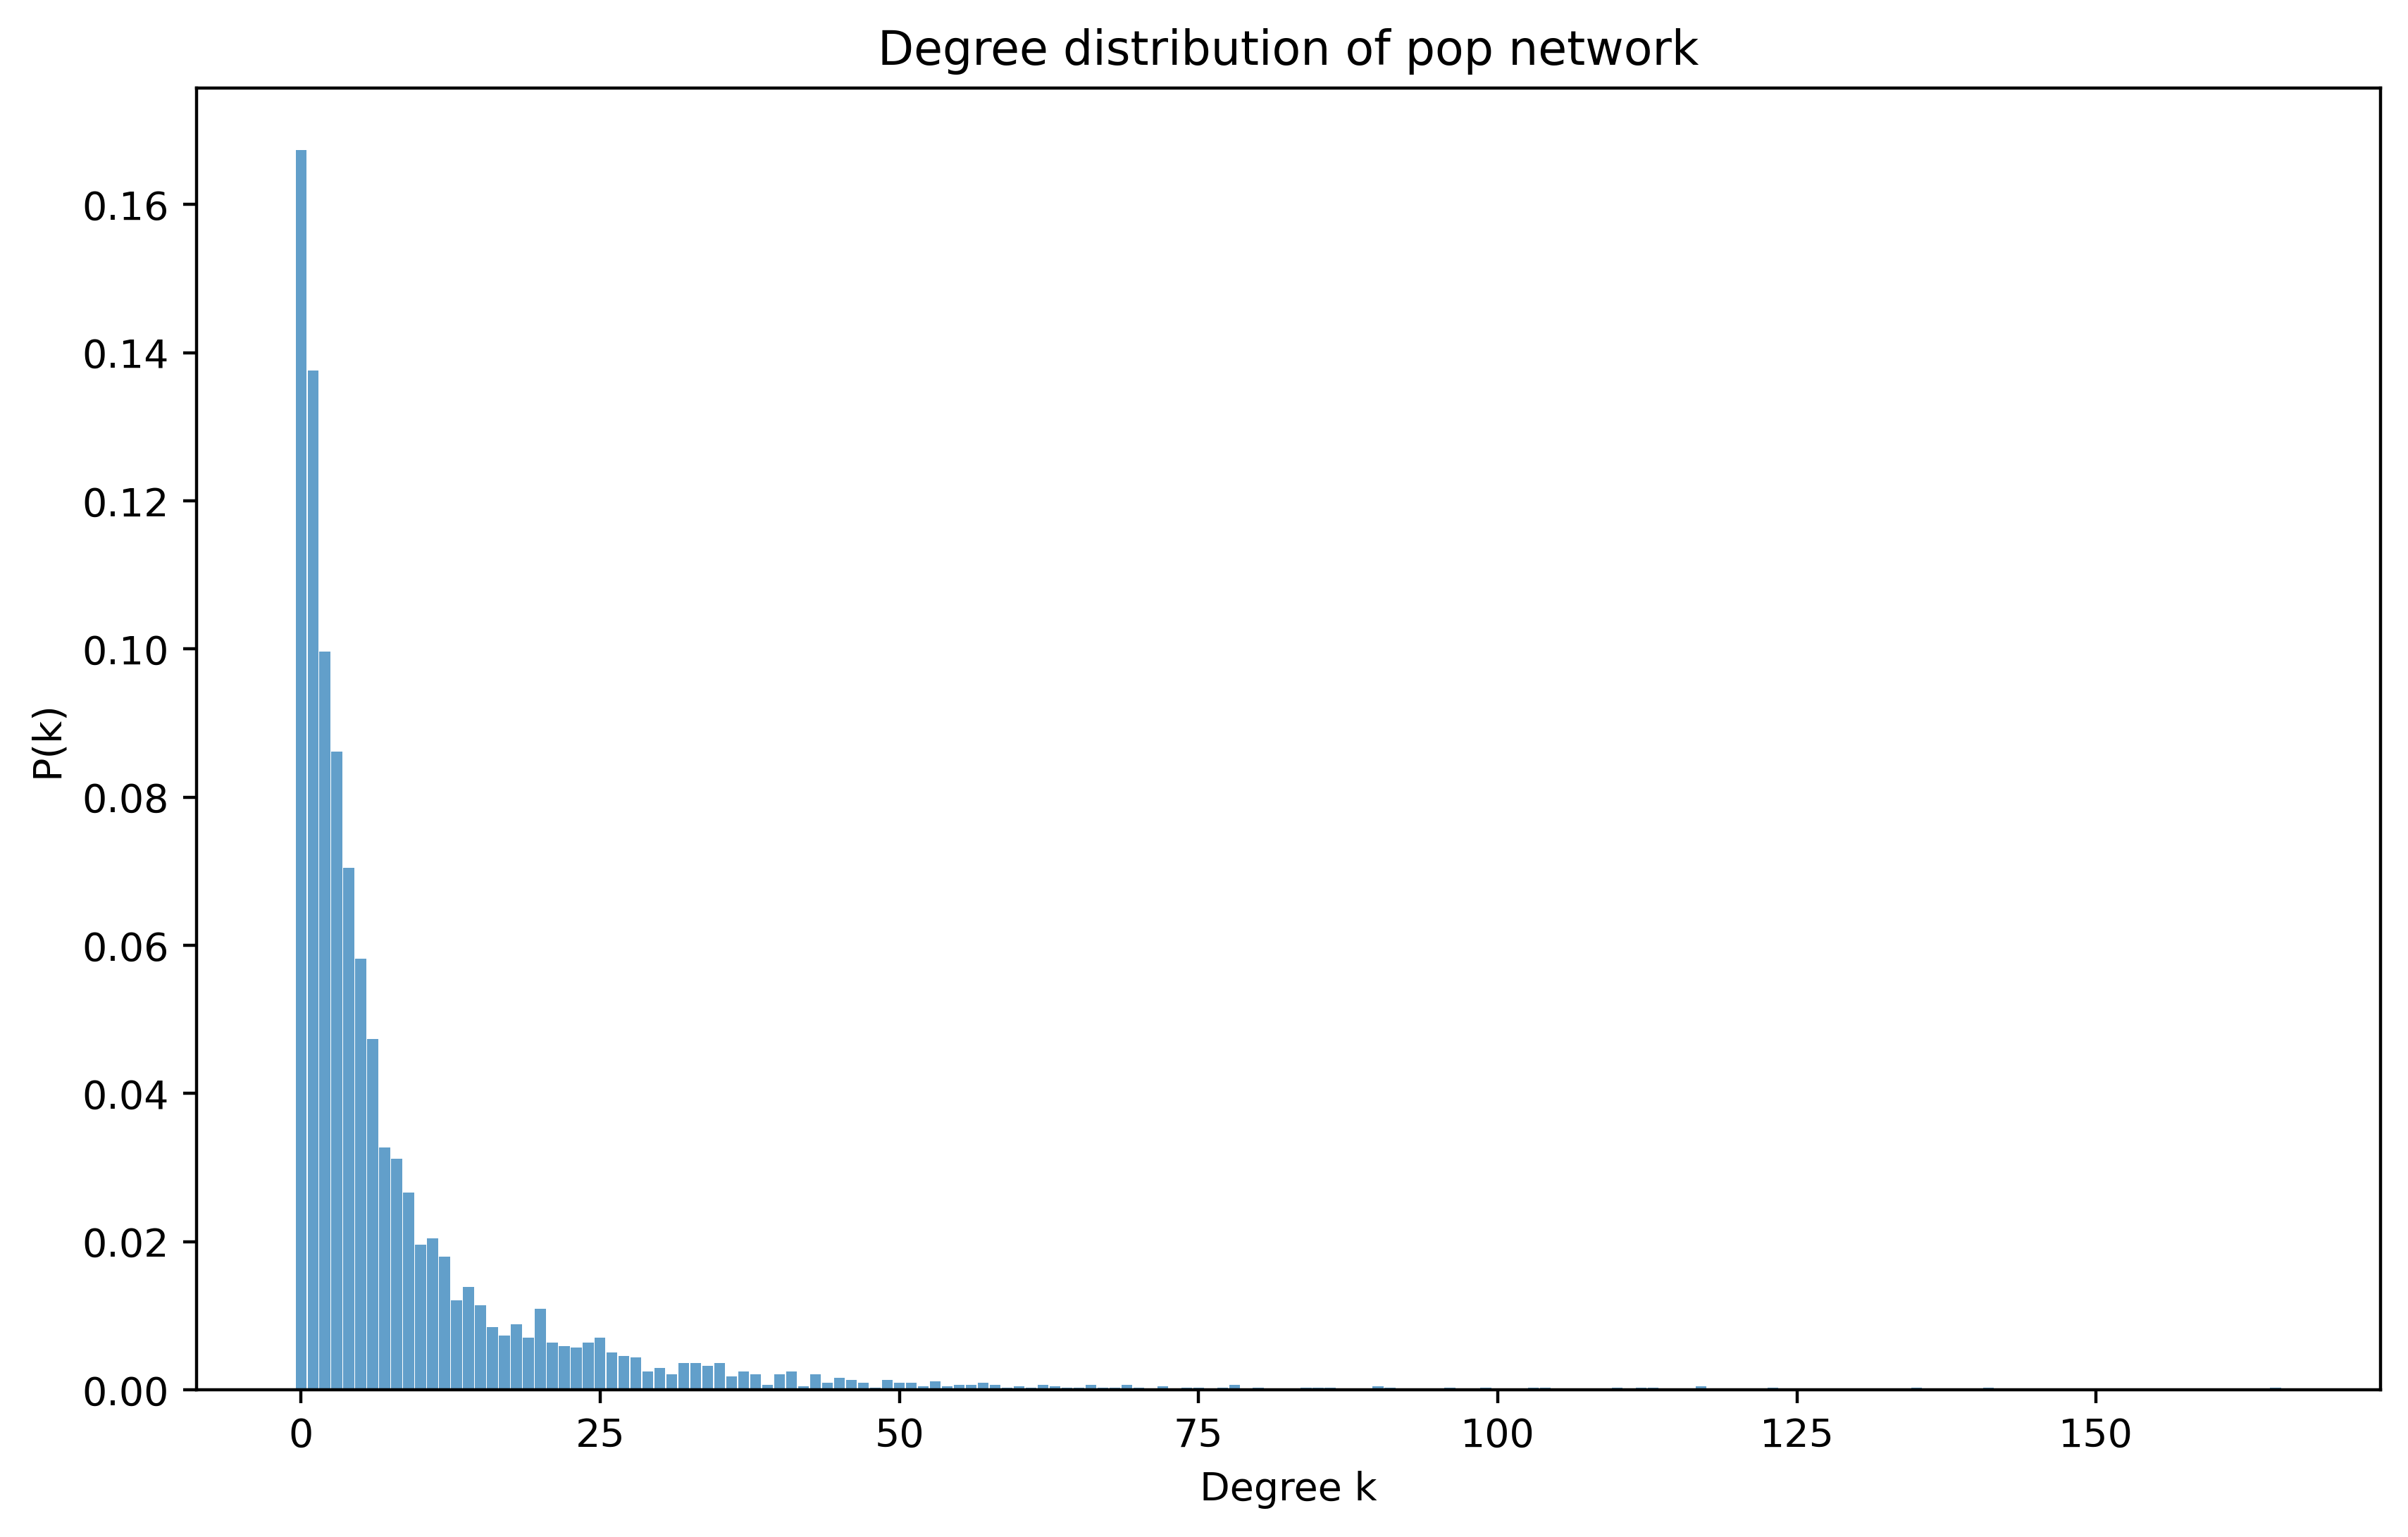

In [28]:
plot_degree_distribution(G_pop)

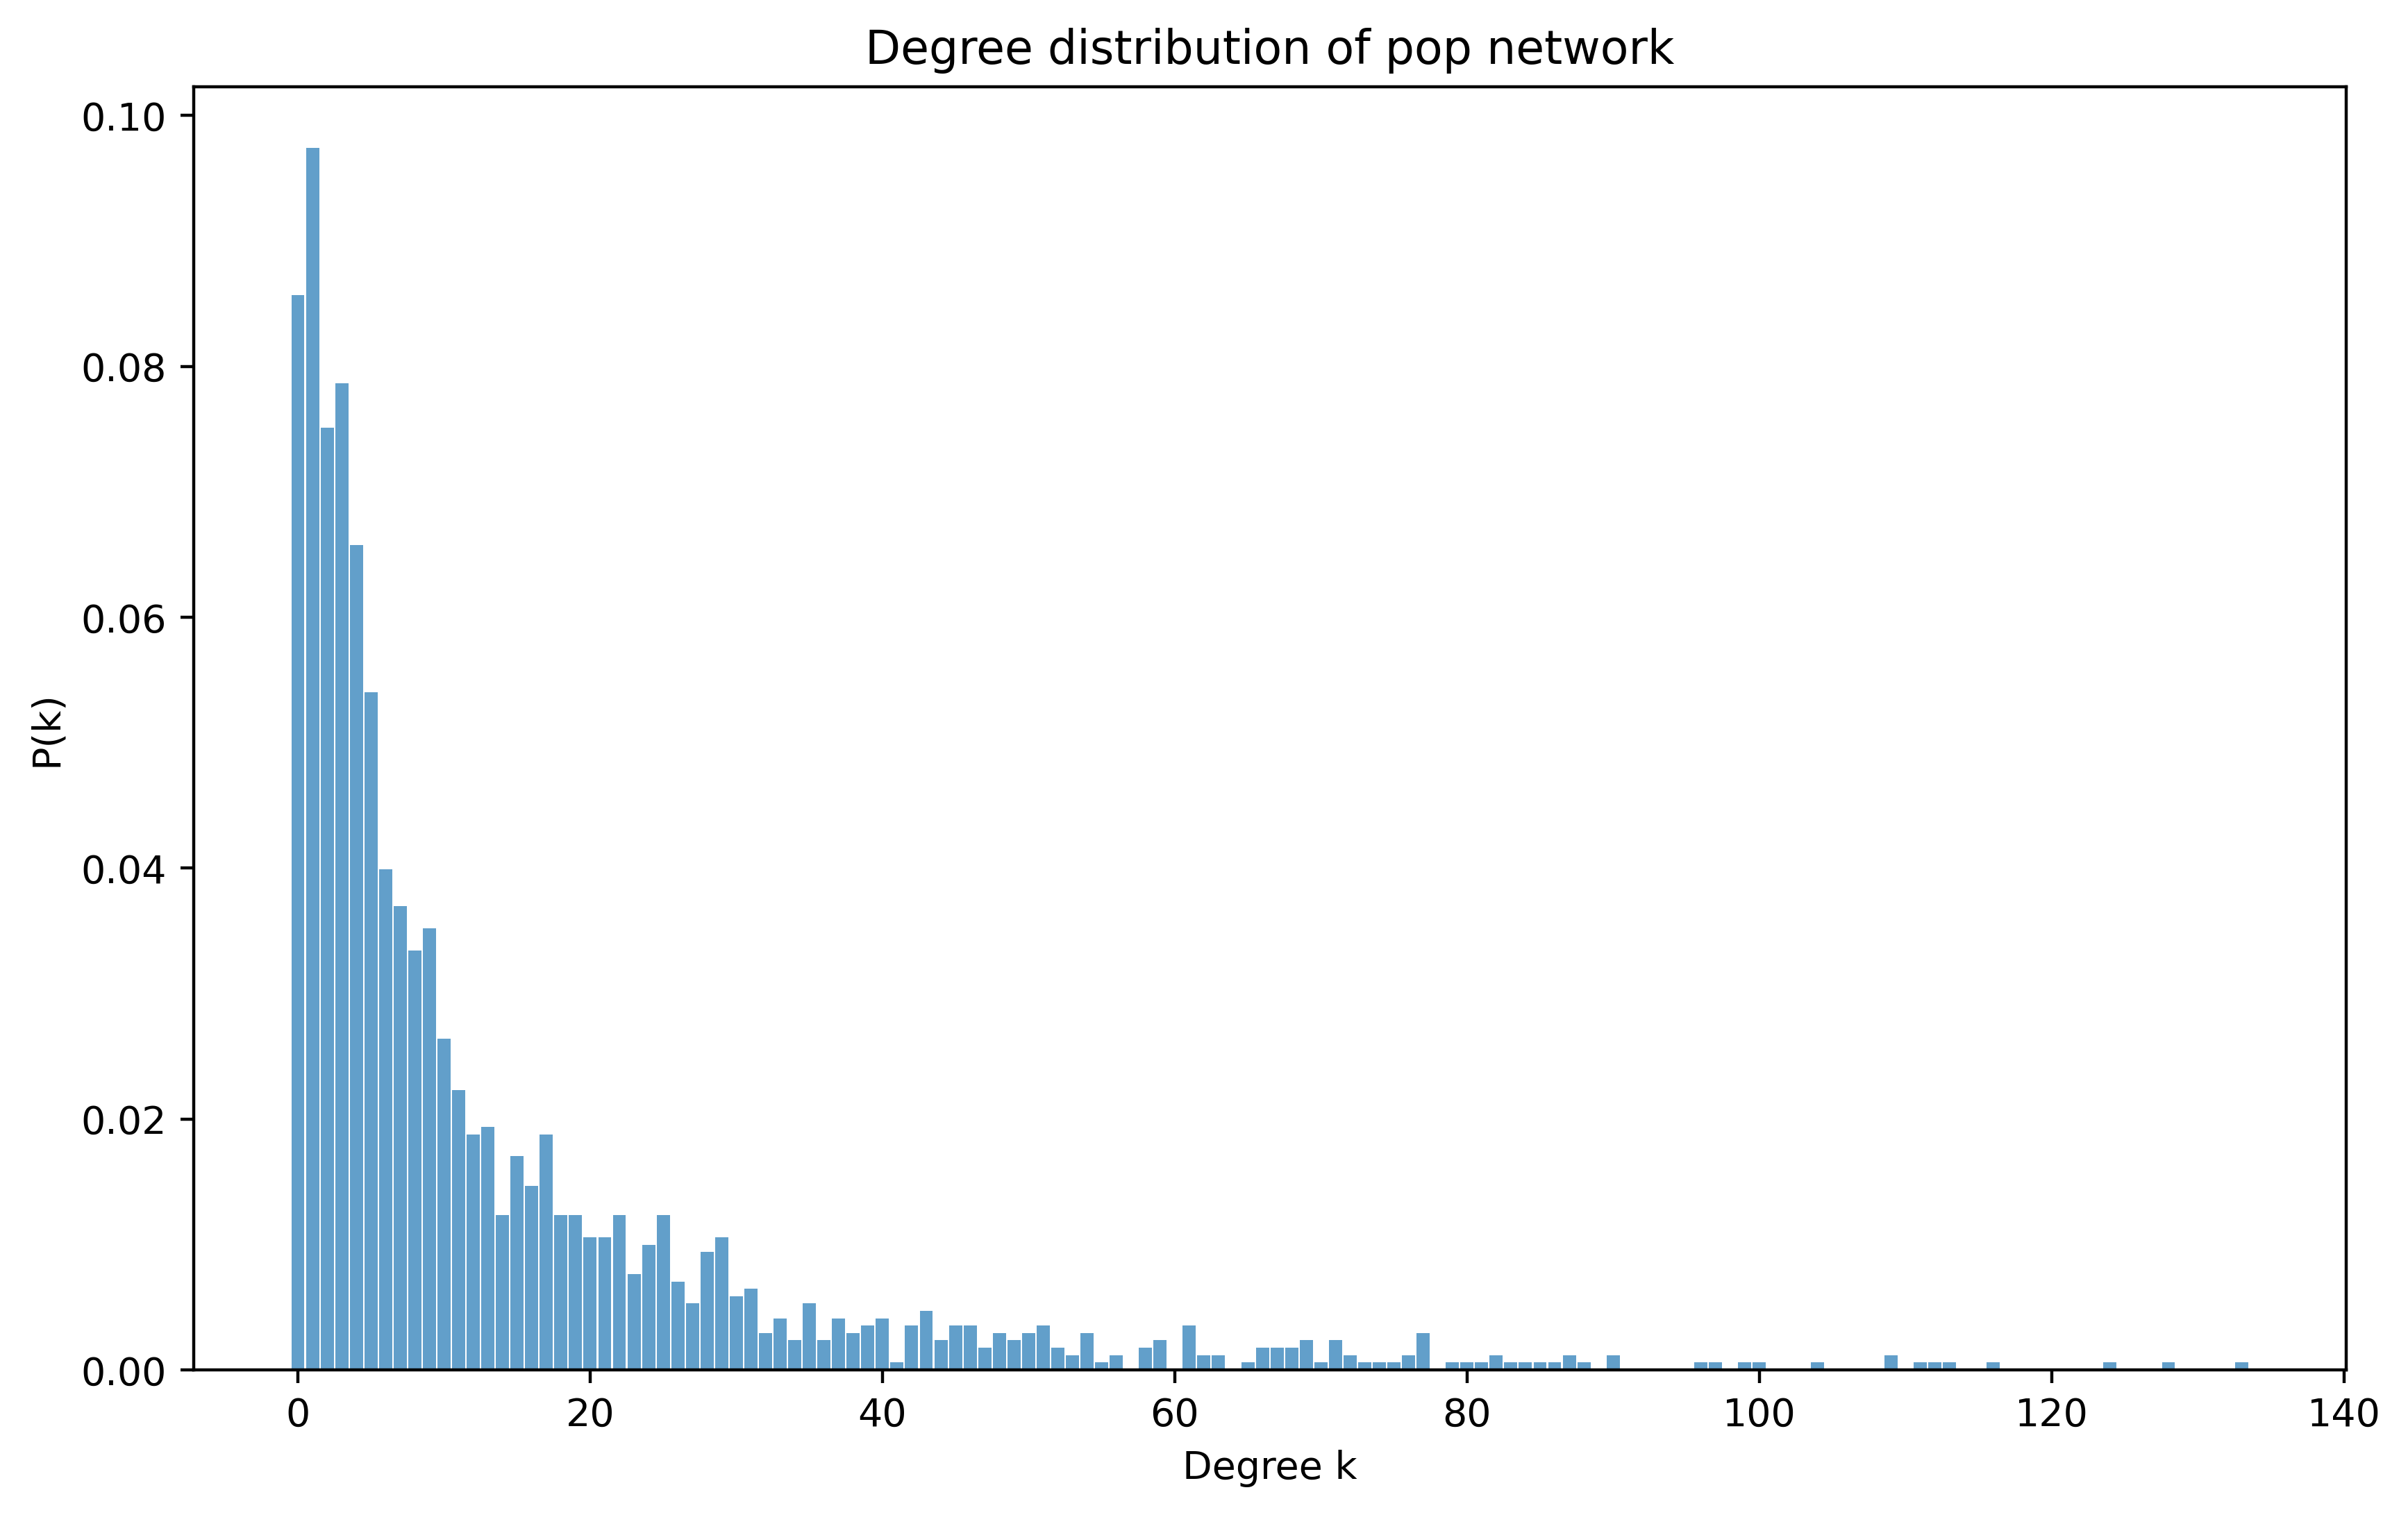

In [29]:
plot_degree_distribution(G_rap)

In [30]:
from Network_statistics import plot_degree_distribution_log_log_scale

Power-law exponent: 1.866


c:\Users\teisa\OneDrive\Skrivebord\DTU\semester 4\Computational Social Science\02467-Project-assignment\Network_statistics.py:85: RuntimeWarning: divide by zero encountered in power
  plt.plot(unique_degrees, C * unique_degrees ** gamma, 'k-', label=r'Power law $P(k) \sim k^{-\gamma}$')


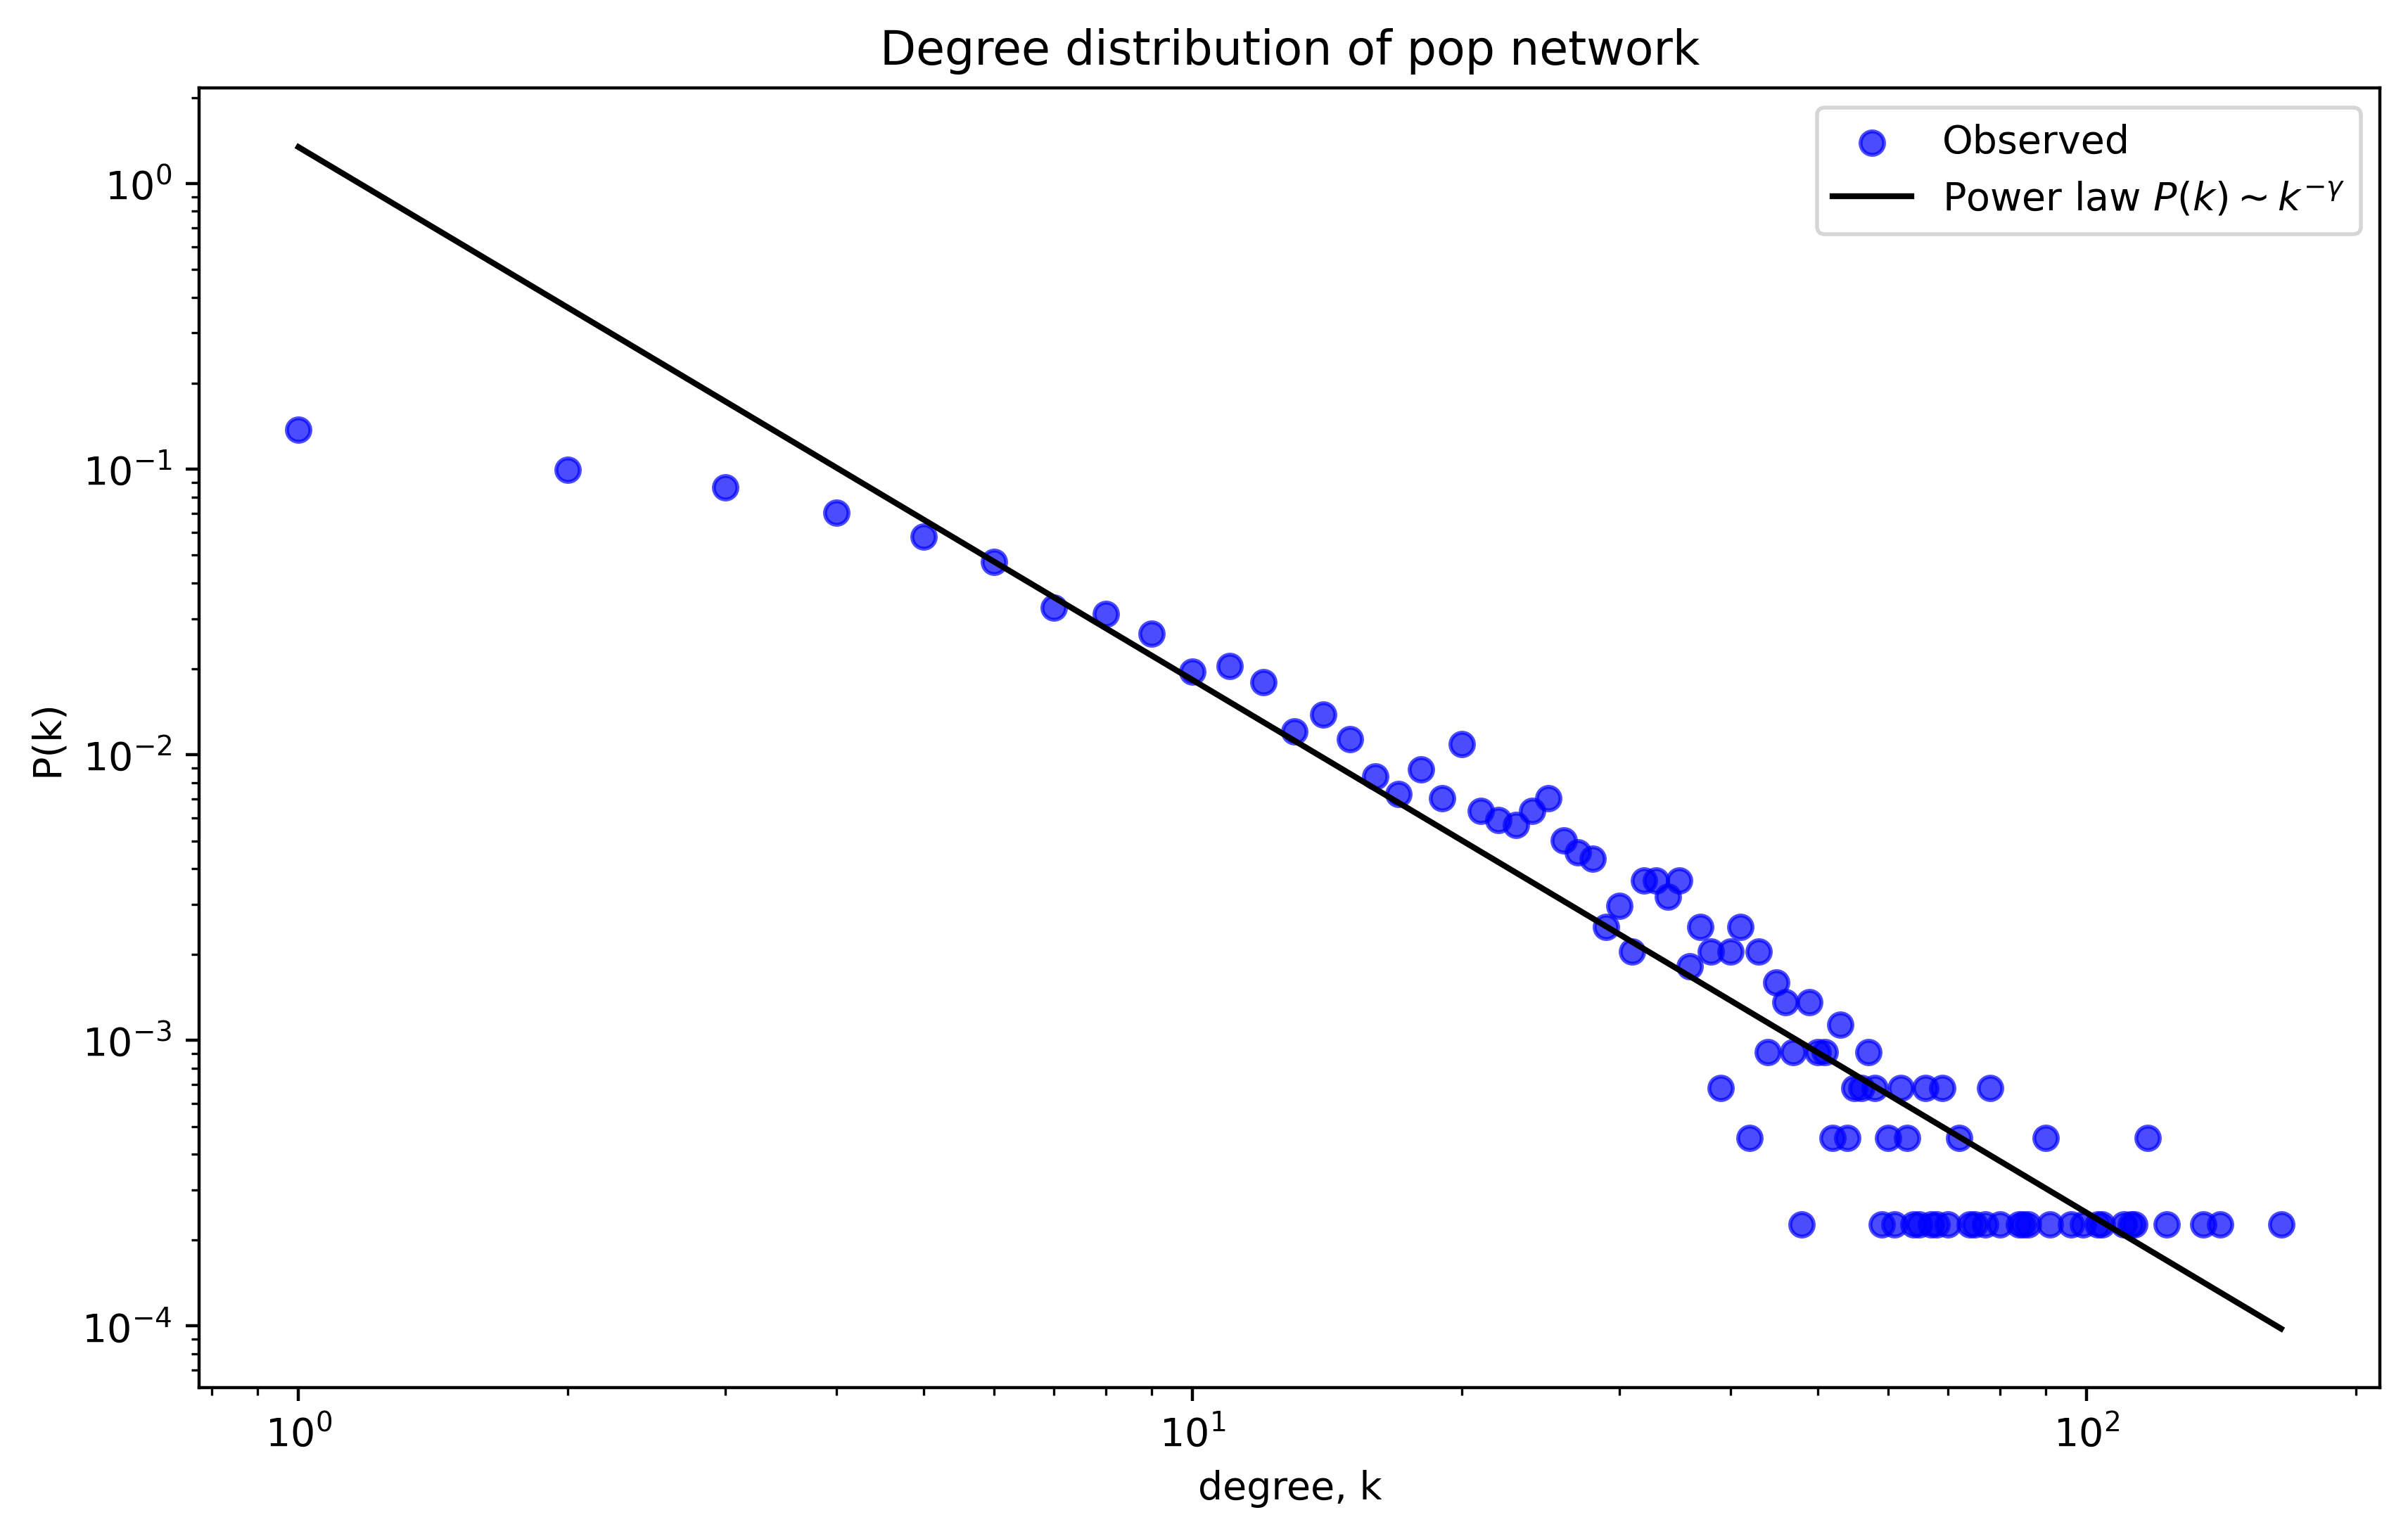

In [31]:
plot_degree_distribution_log_log_scale(G_pop)

Power-law exponent: 1.501


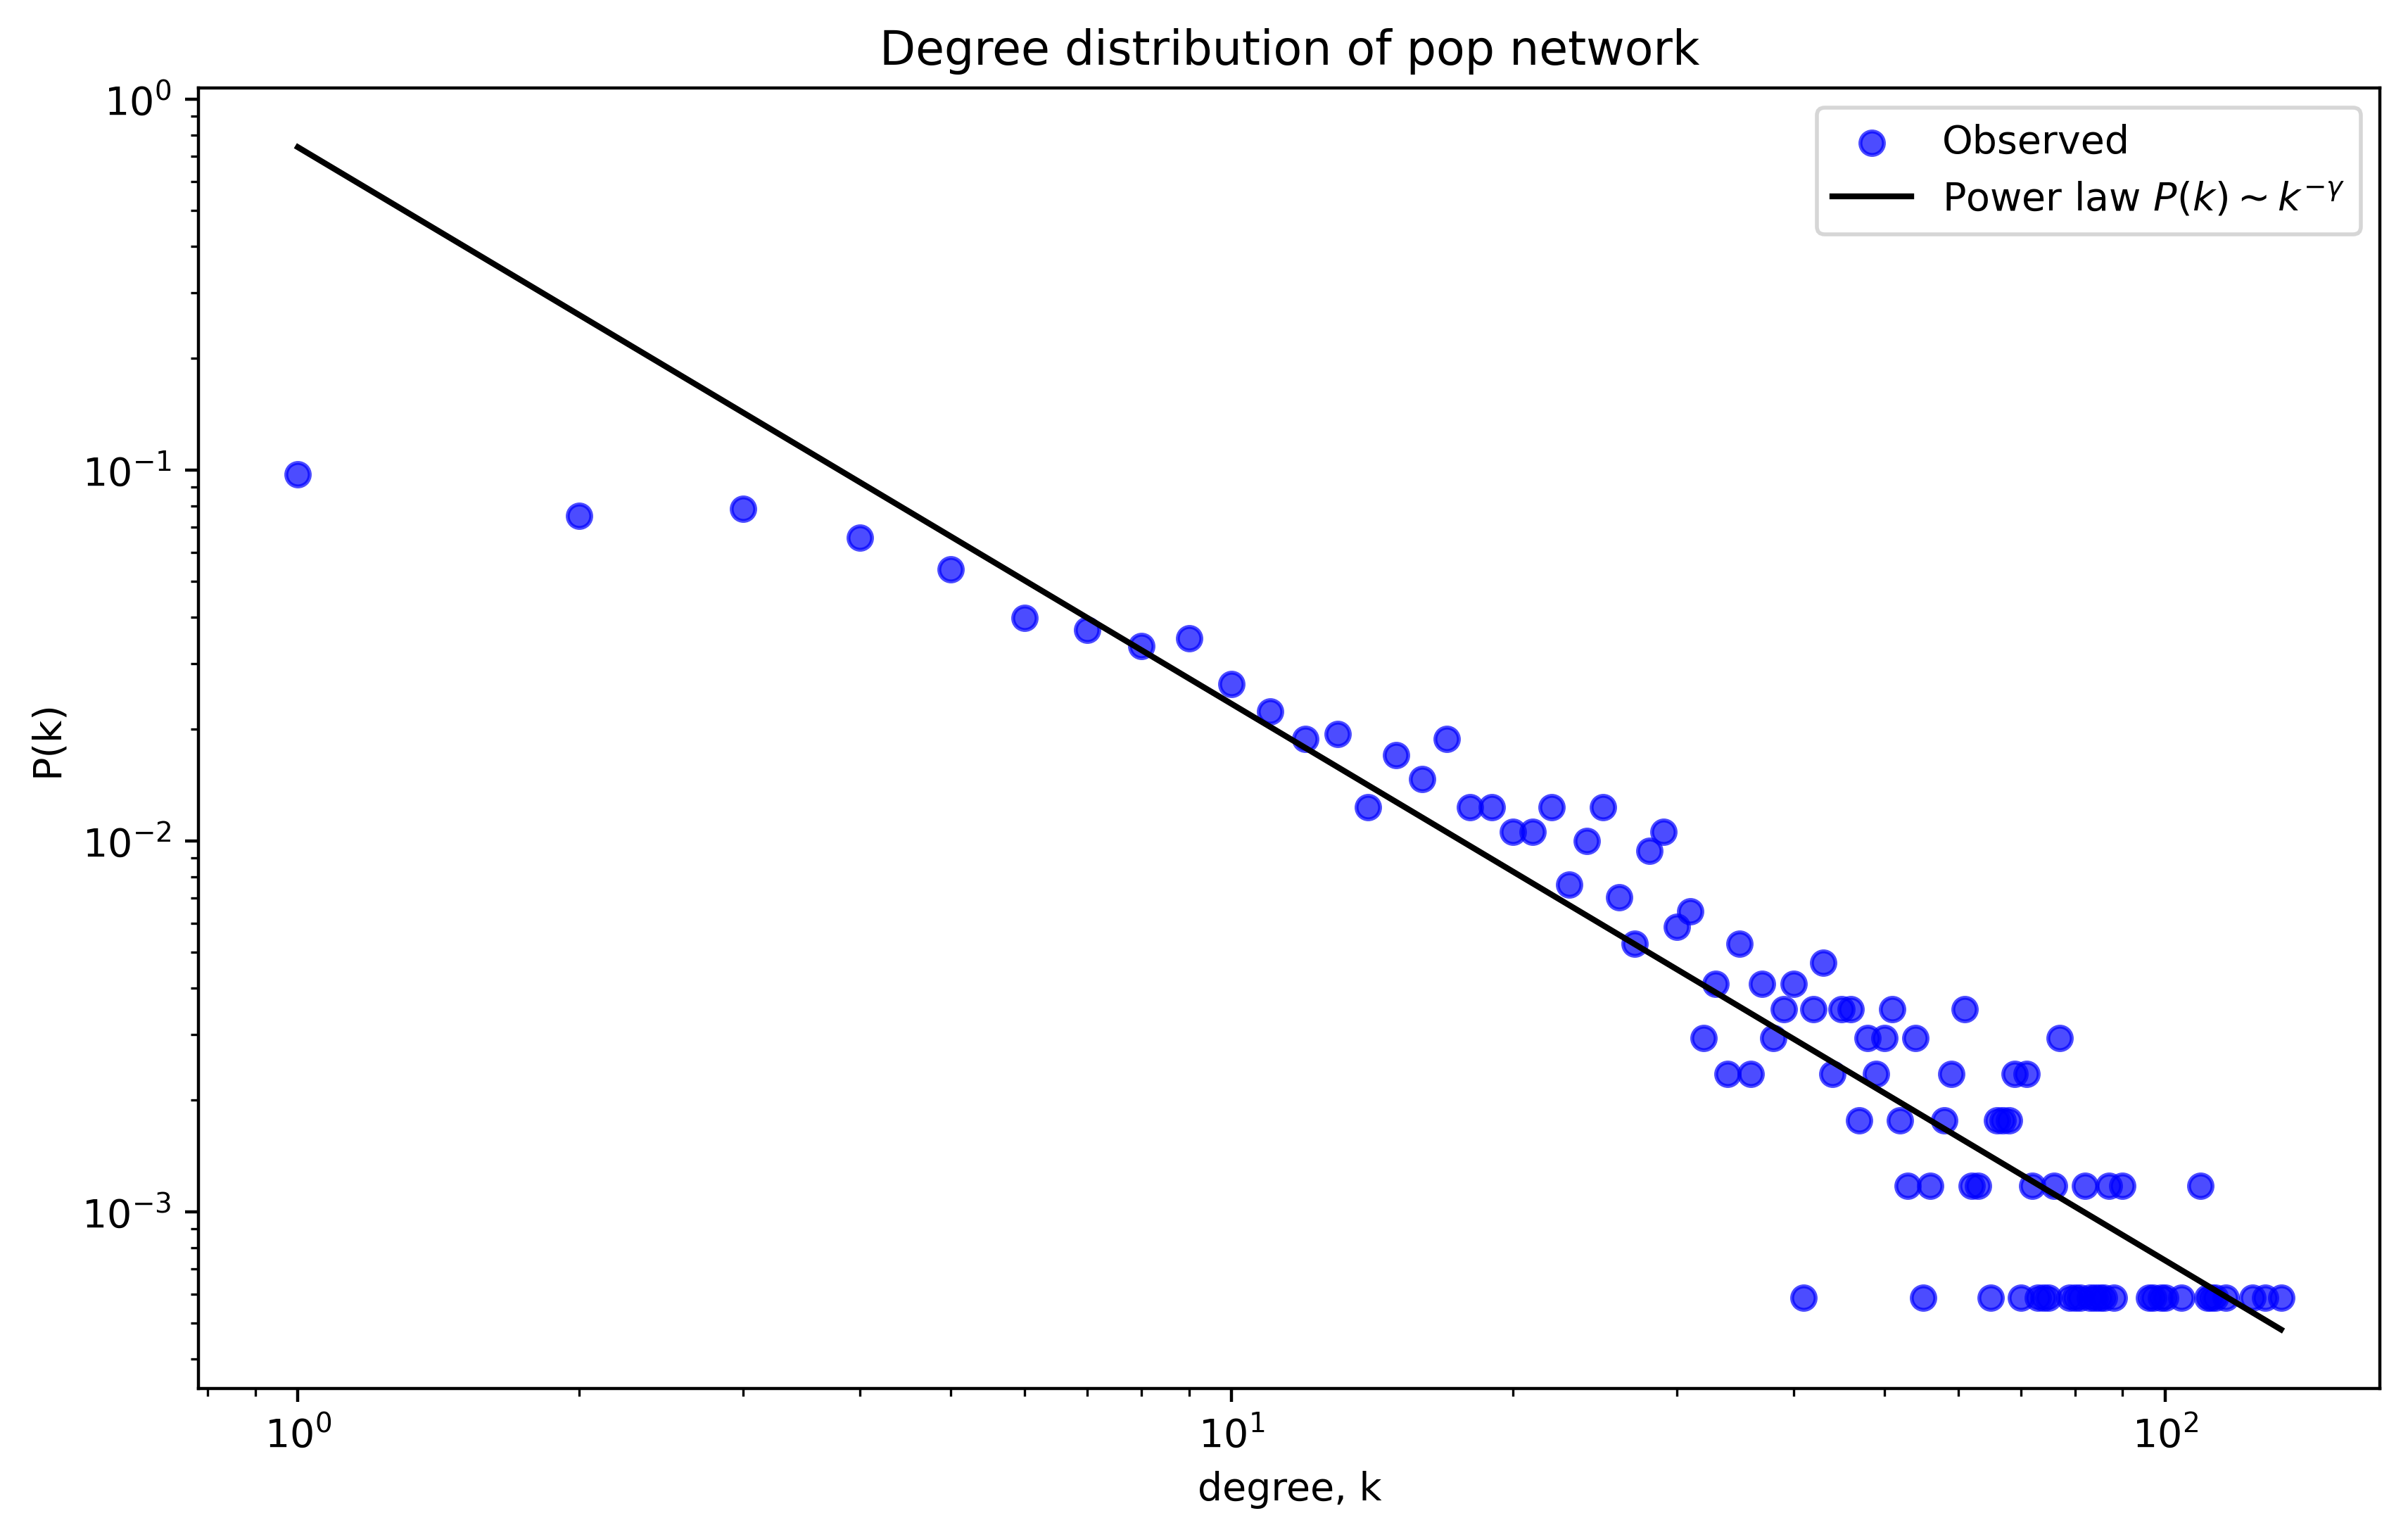

In [32]:
plot_degree_distribution_log_log_scale(G_rap)

## Text gathering

**Brug af Genius:**

# Text analysis

The following section implements and applies all necessary steps for WordClouds using TF-IDF on a graph of artists. It outlines and explains how the process is done with reasoning.

### Introduction of TF-IDF

TF calculates the fraction of a term in a document.

$$TF(t,d) = \frac{f_{t,d}}{\sum_{t' \in d}(f_{t',d})}$$

where $f_{t,d}$ is the count of term $t$ in document $d$.

IDF is calculated as

$$
\text{IDF}(t, d) = \log \left( \frac{N}{\left| \left\{ d \in D \mid t \in d \right\} \right|} \right)
$$

where N is the count of documents in the entire corpus. and $ \left\{ d \in D \mid t \in d \right\} $ is the set of documents containing term t. $\left| \left\{ d \in D \mid t \in d \right\} \right|$ is then the count of documents containing the term t. Summarized IDF returns the log inverse fraction of documents containing the term t in the corpus D.

Combined as the product of the two they give the TF-IDF

$$TFIDF(t,d,D) = tf(t,d)\cdot idf(t,D)$$

This function combines a terms importance within a single document (its internal representation) with its overall significance across the corpus.

### Preprocessing of Lyrics Data

Preprocessing is applied on a copy of the original dataframe to preserve the original data.

- Rows with empty lyrics are assumed to be dropped before this step, as these represent artists whose lyrics could not be fetched via the Genius API.

- The `clean_lyrics_and_apply_representative_text` function combines all lyrics of each artist into a single, semantically representative string.

The text is cleaned in the following ways:
- Removes metadata such as `"Read More\xa0\n"` and the first line (often the title).
- Strips structural tags like `[Verse]`, `[Chorus]`, etc.
- Removes quoted commentary at the beginning of the lyrics.
- Filters out non-letter characters, leaving only alphabetic characters and whitespace.
- Cleans escaped characters (`\n`, `\r`) 
- Removes all whitespace.
- Converts the text to lowercase.

This results in a clean, lowercase string for each artist, ready for semantic analysis.

### Tokenization of Representative Lyrics

After cleaning the lyrics, each artist’s representative text is transformed into a list of tokens through the following process:

- **Stemming and Stopword Removal**: Words are reduced to their stems using a Snowball stemmer. Common English and domain-specific stopwords (e.g., "lyrics", "chorus") are removed.
- **Bigram Detection**: Frequent word pairs (bigrams) are extracted using the chi-squared statistic. Only pairs occurring more than 50 times and with p-value < 0.001 are kept.
- **Retokenization**: Statistically significant bigrams are merged into single tokens using an MWETokenizer for example "hip_hop".

The result is a structured token representation of each artist that can be used for analysis such as TF-IDF and WordClouds.


In [ ]:
# Replace with your actual file path
rap_artists_filename = "rap_df.pkl"

with open(rap_artists_filename, "rb") as file:
    rap_artists_df : pd.DataFrame = pickle.load(file)
    
G_rap # Network used for analysis
rap_communities = community_louvain.best_partition(G_rap)

In [312]:
rap_artists_df.head(3)

,spotify_id,name,followers,popularity,genres,chart_hits,lyrics
0,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"[christlicher rap, german hip hop]","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",[34 ContributorsWölfe LyricsIn dem Lied “Wölfe...
1,2sjnyyL9NXijL3Fr2eLikf,Aspova,339292.0,57,"[turkish hip hop, turkish trap pop]",['tr (12)'],[17 ContributorsNude LyricsEP çıkış tarihinden...
2,5Matrg5du62bXwer29cU5T,Benny The Butcher,266547.0,64,"[boom bap, buffalo hip hop, hip hop, rap, upst...","['us (1)', 'ca (1)', 'za (1)']",[153 ContributorsTranslationsEspañolРусскийPor...


In [313]:
def clean_lyrics_and_apply_representative_text(artist_df):
    artist_df_copy = artist_df.copy()
    def run(lyrics):
        cleaned = []
    
        for raw_lyrics in lyrics:
            # intro before "Read More\xa0\n"
            parts = raw_lyrics.split("Read More\xa0\n")
            lyrics = parts[-1] if parts else raw_lyrics

            # Remove first line often title/commentary
            lyrics_parts = lyrics.split('\n', 1)
            lyrics = lyrics_parts[1] if len(lyrics_parts) > 1 else lyrics_parts[0]

            # Remove [Verse], [Chorus], etc.
            lyrics = re.sub(r'\[.*?\]', '', lyrics)

            # Remove commentary
            lyrics = re.sub(r'^“.*?”\s*', '', lyrics)
            
            lyrics = re.sub(r'[^a-zA-Z\s]', '', lyrics)  # Only letters and spaces

            #Clean escaped characters and whitespace
            lyrics = re.sub(r'\\n|\\r|\r|\n', ' ', lyrics)
            lyrics = re.sub(r'\s+', ' ', lyrics).strip()
            
            lyrics = lyrics.lower()

            cleaned.append(lyrics)

        
        return " ".join(cleaned)
    
    artist_df_copy["representative_text"] = artist_df_copy["lyrics"].apply(run)
    
    return artist_df_copy

def filter_for_english_language(artist_df):
    artist_df_copy = artist_df.copy()
    def is_english(text):
        try:
            return detect(text) == "en"
        except:
            return False

    artist_df_copy["is_english"] = artist_df_copy["representative_text"].apply(is_english)

    artist_df_copy = artist_df_copy[artist_df_copy["is_english"]].reset_index(drop=True)

    return artist_df_copy

def tokenize(artist_df):
        artist_df_copy = artist_df.copy()
        stemmer = SnowballStemmer("english")
        stop_words = set(stopwords.words("english"))

        domain_stopwords = {"song", "lyrics", "chorus", "verse", "repeat"}

        stop_words = stop_words.union(domain_stopwords)
        
        def initial_tokenize(text):
            text = text.lower()
            words = re.findall(r'[a-zA-Z]+', text)
            return [stemmer.stem(word) for word in words if word not in stop_words]

        artist_df_copy["tokens"] = artist_df_copy["representative_text"].apply(initial_tokenize)

        all_tokens = [token for tokens in artist_df_copy["tokens"] for token in tokens]

        finder = BigramCollocationFinder.from_words(all_tokens)
        finder.apply_freq_filter(51)

        bigram_measures = BigramAssocMeasures()
        scored = finder.score_ngrams(bigram_measures.chi_sq)

        collocations = []
        for bigram, score in scored:
            p_value = chi2.sf(score, df=1)
            if p_value < 0.001:
                collocations.append(bigram)

        mwe_tokenizer = MWETokenizer(collocations, separator="_")

        def retokenize(tokens):
            return mwe_tokenizer.tokenize(tokens)

        artist_df_copy["tokens"] = artist_df_copy["tokens"].apply(retokenize)

        return artist_df_copy
    

In [314]:
rap_artists_df_prepared = rap_artists_df.copy()

rap_artists_df_prepared = rap_artists_df_prepared.dropna() # dropna to drop artists whose lyrics was not fetchable using genius

print(f"There exists {len(rap_artists_df_prepared)} artists in the Rap dataframe containing lyrics")

rap_artists_df_prepared = clean_lyrics_and_apply_representative_text(rap_artists_df_prepared)
rap_artists_df_prepared  = tokenize(rap_artists_df_prepared)

rap_artists_df_prepared.head(2)

There exists 1367 artists in the Rap dataframe containing lyrics


,spotify_id,name,followers,popularity,genres,chart_hits,lyrics,representative_text,tokens
0,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"[christlicher rap, german hip hop]","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",[34 ContributorsWölfe LyricsIn dem Lied “Wölfe...,ebenso wie der wolf muss sich der menschen dur...,"[ebenso, wie, der, wolf, muss, sich, der, mens..."
1,2sjnyyL9NXijL3Fr2eLikf,Aspova,339292.0,57,"[turkish hip hop, turkish trap pop]",['tr (12)'],[17 ContributorsNude LyricsEP çıkış tarihinden...,parann ana temas seks ya da nude atmak gibi gz...,"[parann, ana, tema, sek, ya_da, nude, atmak, g..."


### Community-Based TF-IDF Analysis and WordCloud Visualization

This analysis explores linguistic patterns across artist communities using TF-IDF scores to extract key terms for each group and visualise them through word clouds. The process involves grouping, transforming, and analysing preprocessed lyrics data.


In [ ]:
def prepare_community_texts(artists_df, communities):
    df = artists_df.copy()
    df["community"] = df["name"].map(communities)

    grouped = df.groupby("community")

    community_texts = grouped["tokens"].apply(lambda series: sum(series, [])).reset_index()
    community_texts["tokens_length"] = community_texts["tokens"].apply(len)

    return community_texts

def get_top_n_largest_community_ids(communities, n):
    community_counts = Counter(communities.values()) # get the counts of each artist and commmunity pair
    
    sorted_by_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True) # sort in descending by count.
    top_n_community_ids = np.array([id_and_count[0] for id_and_count in sorted_by_counts[:n]])

    return top_n_community_ids

def get_TF_dataframe(community_texts):
    communities_df_expanded = community_texts.copy() # Copy top 5 communities to not make a mess
    exploded = communities_df_expanded.explode("tokens") # Explode into tokens

    token_counts  = exploded.groupby(["community", "tokens"]).size().reset_index(name="count")
    # group inside each community and get the token count store it in column "count"

    total_tokens = exploded.groupby("community").size().reset_index(name="total")
    # Group only by community such we can get the total counts

    tf_df = token_counts.merge(total_tokens, on="community") # Merge total_tokens onto token_counts so we can divide after and get the TF

    tf_df["TF"] = tf_df["count"] / tf_df["total"]
    
    return tf_df

def get_IDF_dataframe(community_texts):
    community_texts_expanded = community_texts.copy() # Copy the community text to not make a mess
    exploded = community_texts_expanded.explode("tokens") # Explode into tokens

    community_token_pairs = exploded[["community", "tokens"]].drop_duplicates() 
    # Removing all duplicates as we just need to know if community i has token j.

    token_to_community_count = community_token_pairs.groupby("tokens").size().reset_index(name="tokenInCommunityCount") 
    # Count how many communities the token exists in.

    N = len(community_texts)

    IDF_df = token_to_community_count
    IDF_df["idf"] = np.log(N / IDF_df["tokenInCommunityCount"])

    return IDF_df
    
def get_TF_IDF_dataframe(tf_df, IDF_df):
    tf_idf_df = tf_df.copy().merge(IDF_df[["tokens", "idf"]], on="tokens", how="left") # Merge the idf_values onto each token in tf_df. 
    # To prepare for calculating the tf-idf value.

    tf_idf_df["tf-idf"] = tf_idf_df["TF"] * tf_idf_df["idf"]

    return tf_idf_df

def print_top_5_TF_per_community(tf_df):
    sorted_descending_by_tf = tf_df.sort_values(["TF"], ascending=[False]) # Sort it decending order by TF such term with highest TF is up.
    top_5_per_community = sorted_descending_by_tf.groupby("community").head(5).reset_index()
    # Grouping by community to then get the 5 largest by .head(5) as they are sorted descendingly. Finnaly reshaping back using reset_index.

    top_5_per_community_sorted = top_5_per_community.sort_values(["community"]) # sort such we get the terms 
    # for each community next to each other. Easier when printing

    print(f"{len(top_5_per_community_sorted)} terms")

    for i in range(0,len(top_5_per_community_sorted),5):
        print(f"Community: {top_5_per_community_sorted.iloc[i]["community"]}, 5 Terms: {top_5_per_community_sorted[i: i+5]["tokens"].to_list()}")

def print_top_10_tf_idf_tokens(tf_idf_df):
    sorted_descending_by_tf_idf = tf_idf_df.sort_values(["tf-idf"], ascending=[False]) # Sort it decending order by 'tf-idf' such term with 
    # highest tf-idf is furthest up.
    top_10_per_community = sorted_descending_by_tf_idf.groupby("community").head(10).reset_index()
    # Grouping by community to then get the 10 largest using .head(10) as they are sorted descendingly. Finnaly reshaping back using reset_index.

    top_10_per_community_sorted = top_10_per_community.sort_values(["community"]) # sort such we get the terms 
    # for each community next to each other. Easier when printing

    print(f"{len(top_10_per_community_sorted)} terms")

    for i in range(0, len(top_10_per_community_sorted), 10):
        print(f"Community: {top_10_per_community_sorted.iloc[i]["community"]}, 10 Terms: {top_10_per_community_sorted[i: i+10]["tokens"].to_list()}")
        
def get_community_to_top_n_artists_by_followers(community_ids, artist_to_community, artist_df, n=3):
    community_to_top_n = defaultdict(list)

    for community_id in community_ids:
        # Find all artist names in this community
        community_artists = [
            artist for artist, comm_id in artist_to_community.items()
            if comm_id == community_id
        ]

        # Filter artist_df to include only those artists
        community_artist_df = artist_df[artist_df["name"].isin(community_artists)]

        # Sort by followers
        sorted_df = community_artist_df.sort_values(by="followers", ascending=False)

        # Get top 3 artists
        top_artists = sorted_df["name"].head(n).tolist()
        community_to_top_n[community_id] = top_artists

    return community_to_top_n

def plot_wordcloud(tf_idf_df, top_communities, community_to_top_3_authors, n=100):

    # Sort by tf-idf score descending
    sorted_descending_by_tf_idf = tf_idf_df.sort_values("tf-idf", ascending=False)

    # Get top-n per community
    top_n_per_community = (
        sorted_descending_by_tf_idf.groupby("community").head(n).reset_index(drop=True)
    )

    # Sort by community number
    top_n_per_community_sorted = top_n_per_community.sort_values("community")

    num_communities = len(top_communities)
    cols = 3  # You can change this default
    rows = math.ceil(num_communities / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for idx, community in enumerate(top_communities["community"]):
        top_words_df = top_n_per_community_sorted[
            top_n_per_community_sorted["community"] == community
        ]
        word_freq = dict(zip(top_words_df["tokens"], top_words_df["tf-idf"]))

        authors = community_to_top_3_authors.get(community, [])
        author_str = "\n".join(authors)

        wc = WordCloud(width=800, height=600, background_color="white").generate_from_frequencies(word_freq)

        axes[idx].imshow(wc, interpolation="bilinear")
        axes[idx].set_title(f"Community {community}\n\n{author_str}", fontsize=14, pad=20)
        axes[idx].axis("off")

    # Turn off any extra axes (if grid > number of communities)
    for j in range(num_communities, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
    
def run_tf_idf_wordcloud_analysis(artists_df, communities, verbose=True):
    artists_df_prepared = artists_df.copy()
    artists_df_prepared = artists_df_prepared.dropna()
    artists_df_prepared = clean_lyrics_and_apply_representative_text(artists_df_prepared)
    artists_df_prepared  = tokenize(artists_df_prepared)
    
    if verbose:
        print(f"\n Applying word cloud analysis on dataframe containing {len(artists_df)} artists")
        print(f"\n {len(artists_df_prepared)} artists were found containing lyrics")
        print(f"\n {len(set(communities.values()))} unique communities were found")
        
    community_texts_df = prepare_community_texts(artists_df_prepared, communities)
    
    top_5_community_ids = get_top_n_largest_community_ids(rap_communities, 5)
    top_5_community_texts_df = community_texts_df[community_texts_df["community"].isin(top_5_community_ids)]
    top_5_community_texts_df = top_5_community_texts_df.sort_values(
        by="community",
        key=lambda col: col.map({cid: i for i, cid in enumerate(top_5_community_texts_df)})
    )

    tf_df = get_TF_dataframe(top_5_community_texts_df)
    idf_df = get_IDF_dataframe(community_texts_df)
    TF_IDF_df = get_TF_IDF_dataframe(tf_df, idf_df)
    
    if verbose:
        print("\n ---- top 5 TF terms per community ---- \n")
        print_top_5_TF_per_community(tf_df)
        print("\n ---- Top 10 TF-IDf terms per community ---- \n")
        print_top_10_tf_idf_tokens(TF_IDF_df)

    communitiy_to_top_artists = get_community_to_top_n_artists_by_followers(top_5_community_ids, communities, artists_df, 3)
    
    plot_wordcloud(TF_IDF_df, top_5_community_texts_df, communitiy_to_top_artists)

#### 1. Grouping Lyrics by Community

We begin by aggregating tokenized lyrics at the **community level** using the `prepare_community_texts()` function:

Next, we extract the top 5 largest communities, where "largest" is defined by the number of artists assigned to each community.

In [356]:
print(f"{len(rap_artists_df)} artists in the rap dataframe")
print(f"{len(rap_artists_df_prepared)} artists in the rap dataframe containing lyrics")
print(f"{len(set(rap_communities.values()))} unique communities in the rap network - using louvain ")

rap_community_texts_df = prepare_community_texts(rap_artists_df_prepared, rap_communities)

rap_top_5_community_ids = get_top_n_largest_community_ids(rap_communities, 5)

rap_top_5_community_texts_df = rap_community_texts_df[rap_community_texts_df["community"].isin(rap_top_5_community_ids)]

rap_top_5_community_texts_df = rap_top_5_community_texts_df.sort_values(
    by="community",
    key=lambda col: col.map({cid: i for i, cid in enumerate(rap_top_5_community_ids)})
)

print(f"Top 5 communities by amount of members")

rap_top_5_community_texts_df

1704 artists in the rap dataframe
1367 artists in the rap dataframe containing lyrics
173 unique communities in the rap network - using louvain 
Top 5 communities by amount of members


,community,tokens,tokens_length
1,2,"[yeah_know, tana, talk, nigga, shit, mean, lot...",250193
4,5,"[fuego, yeah, ant, llamaba, al, iphon, cuando,...",294573
0,1,"[ebenso, wie, der, wolf, muss, sich, der, mens...",142021
13,14,"[zie, ik_een, opp, ik, dip, meteen, take, man,...",126950
10,11,"[morceau, plutt, sombr, guizmo, regrett, les, ...",147045


#### 2. Calculating TF, IDF, and TF-IDF Scores

With the top 5 communities selected, we now calculate word importance within and across communities using Term Frequency (TF), Inverse Document Frequency (IDF), and TF-IDF scores.


In [ ]:
rap_tf_df = get_TF_dataframe(rap_top_5_community_texts_df)
rap_idf_df = get_IDF_dataframe(rap_community_texts_df)
rap_TF_IDF_df = get_TF_IDF_dataframe(rap_tf_df, rap_idf_df)

print("---Top 5 terms in Rap communities using TF---")        
print_top_5_TF_per_community(rap_tf_df)

print("---Top 5 terms in Rap communities using TF-iDF---")        
print_top_10_tf_idf_tokens(rap_TF_IDF_df)


---Top 5 terms in Rap communities using TF---
25 terms
Community: 1, 5 Terms: ['ich', 'und', 'bi', 'die', 'bu']
Community: 2, 5 Terms: ['im', 'like', 'nigga', 'yeah', 'got']
Community: 5, 5 Terms: ['te', 'la', 'que', 'el', 'de']
Community: 11, 5 Terms: ['de', 'pas', 'la', 'le', 'les']
Community: 14, 5 Terms: ['je', 'de', 'die', 'ik', 'het']
---Top 5 terms in Rap communities using TF-iDF---
50 terms
Community: 1, 10 Terms: ['ich', 'und', 'nicht', 'bi', 'die', 'bu', 'ist', 'der', 'auf', 'mein']
Community: 2, 10 Terms: ['get', 'bitch', 'like', 'im', 'got', 'nigga', 'shit', 'gon', 'know', 'aint']
Community: 5, 10 Terms: ['de', 'te', 'pero', 'pa', 'los', 'la', 'el', 'que', 'lo', 'en_la']
Community: 11, 10 Terms: ['le', 'les', 'cest', 'jsui', 'de', 'jai', 'et', 'la', 'des', 'pas']
Community: 14, 10 Terms: ['jij', 'mn', 'je', 'niet', 'het', 'ik_ben', 'een', 'ik', 'ze', 'maar']


#### 3. Identifying Top Artists per Community

To make the visualisation more informative we identify the **top artists by followers** in each of the 5 selected communities.

In [340]:
n=3

rap_communitiy_to_top_artists = get_community_to_top_n_artists_by_followers(rap_top_5_community_ids, rap_communities, rap_artists_df, n)

for community_id, top_artists in rap_communitiy_to_top_artists.items():
    print(f"Top {n} artists by followers in community {community_id}: {', '.join(top_artists)}")

Top 3 artists by followers in community 2: Drake, Eminem, Post Malone
Top 3 artists by followers in community 5: Bad Bunny, J Balvin, Ozuna
Top 3 artists by followers in community 1: Ezhel, Sagopa Kajmer, Ceza
Top 3 artists by followers in community 14: Djadja & Dinaz, Lil Kleine, Yellow Claw
Top 3 artists by followers in community 11: Jul, Damso, Soolking


#### 4. Visualising Community-Specific Language with Word Clouds

In the final step, we generate a **word cloud** for each of the top 5 communities using their most distinctive terms determined by TF-IDF scores.

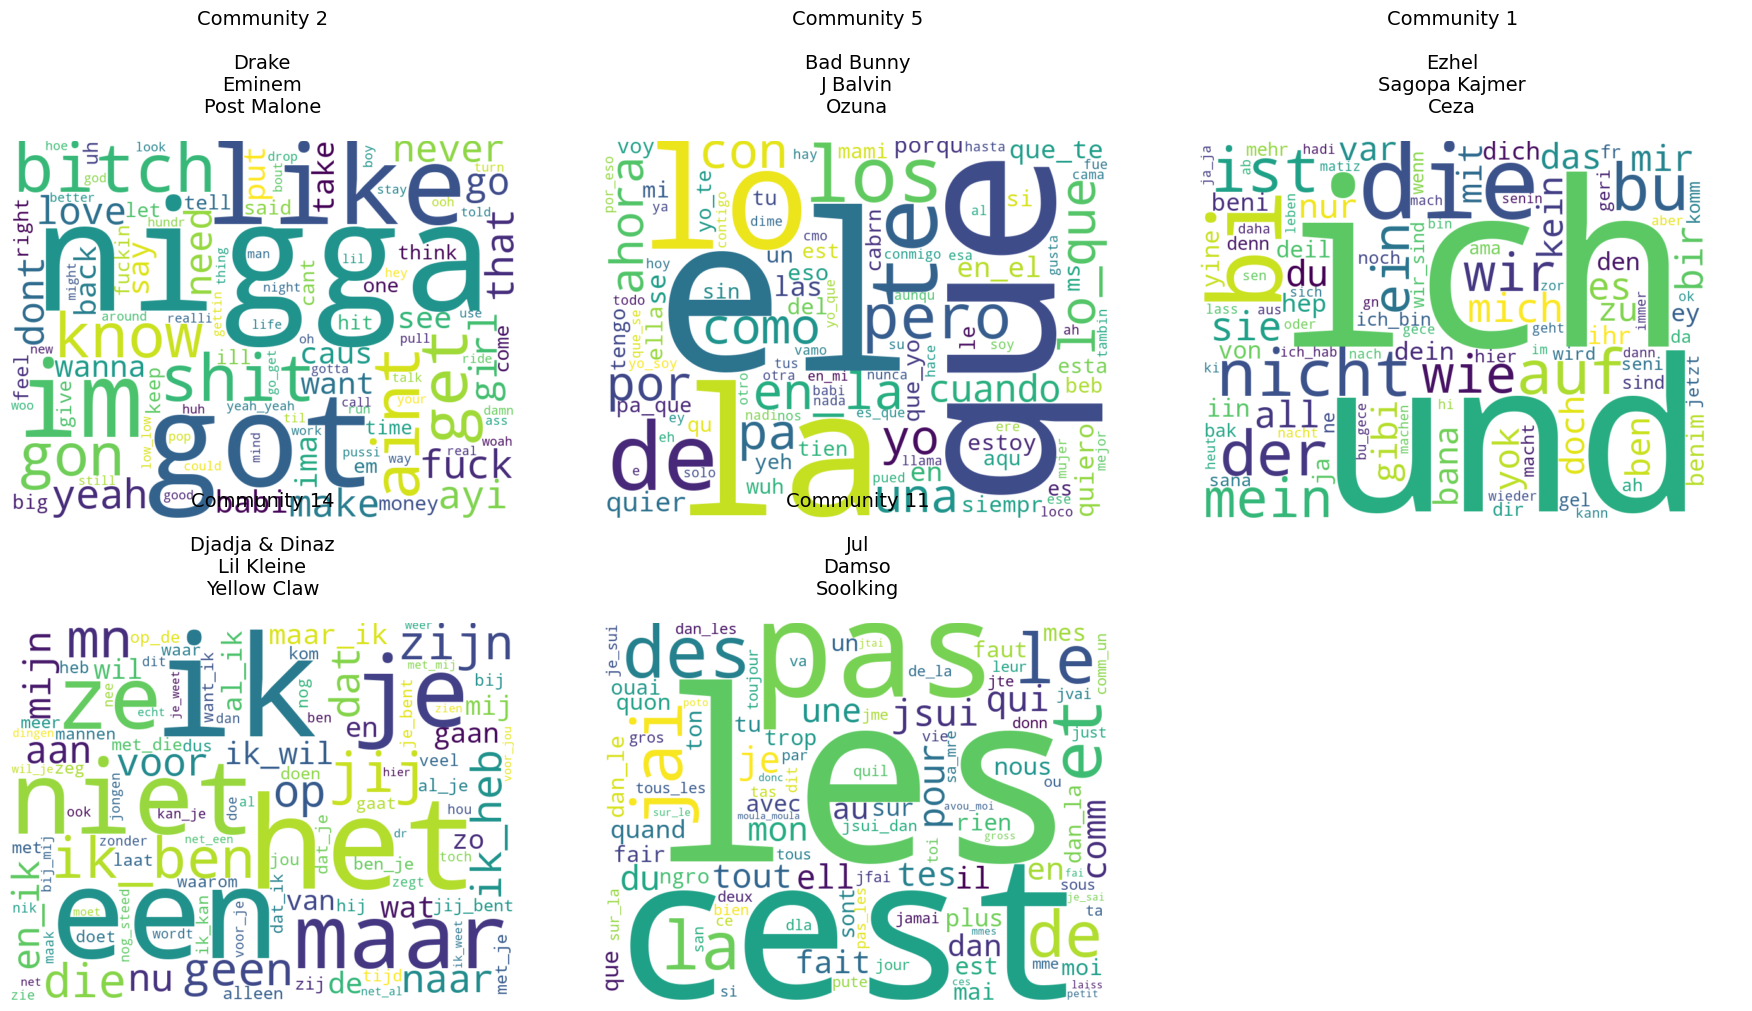

In [347]:
plot_wordcloud(rap_TF_IDF_df, rap_top_5_community_texts_df, rap_communitiy_to_top_artists)

### Running Word Cloud Analysis on Pop Network

We now apply the same TF-IDF and word cloud procedure to the **pop music artist network**


 Applying word cloud analysis on dataframe containing 4398 artists

 3746 artists were found containing lyrics

 799 unique communities were found

 ---- top 5 TF terms per community ---- 

25 terms
Community: 1, 5 Terms: ['like', 'im', 'your', 'love', 'oh']
Community: 2, 5 Terms: ['like', 'im', 'see', 'go', 'make']
Community: 5, 5 Terms: ['te', 'de', 'que', 'la', 'el']
Community: 11, 5 Terms: ['da', 'mo', 'wa', 'ni', 'yo']
Community: 14, 5 Terms: ['got', 'like', 'im', 'yeah', 'nigga']

 ---- Top 10 TF-IDf terms per community ---- 

50 terms
Community: 1, 10 Terms: ['im', 'your', 'know', 'get', 'oh', 'love', 'like', 'keep', 'go', 'got']
Community: 2, 10 Terms: ['yi', 'im', 'bout', 'like', 'nigga', 'good_right', 'shit', 'xing', 'zai', 'see']
Community: 5, 10 Terms: ['el', 'de', 'la', 'te', 'pero', 'lo', 'yo', 'un', 'que', 'si']
Community: 11, 10 Terms: ['anata', 'tururutu', 'suki', 'wo', 'ni', 'mo', 'yo', 'kara', 'zutto', 'wa']
Community: 14, 10 Terms: ['fuck', 'aint', 'im', 'shit', 'g

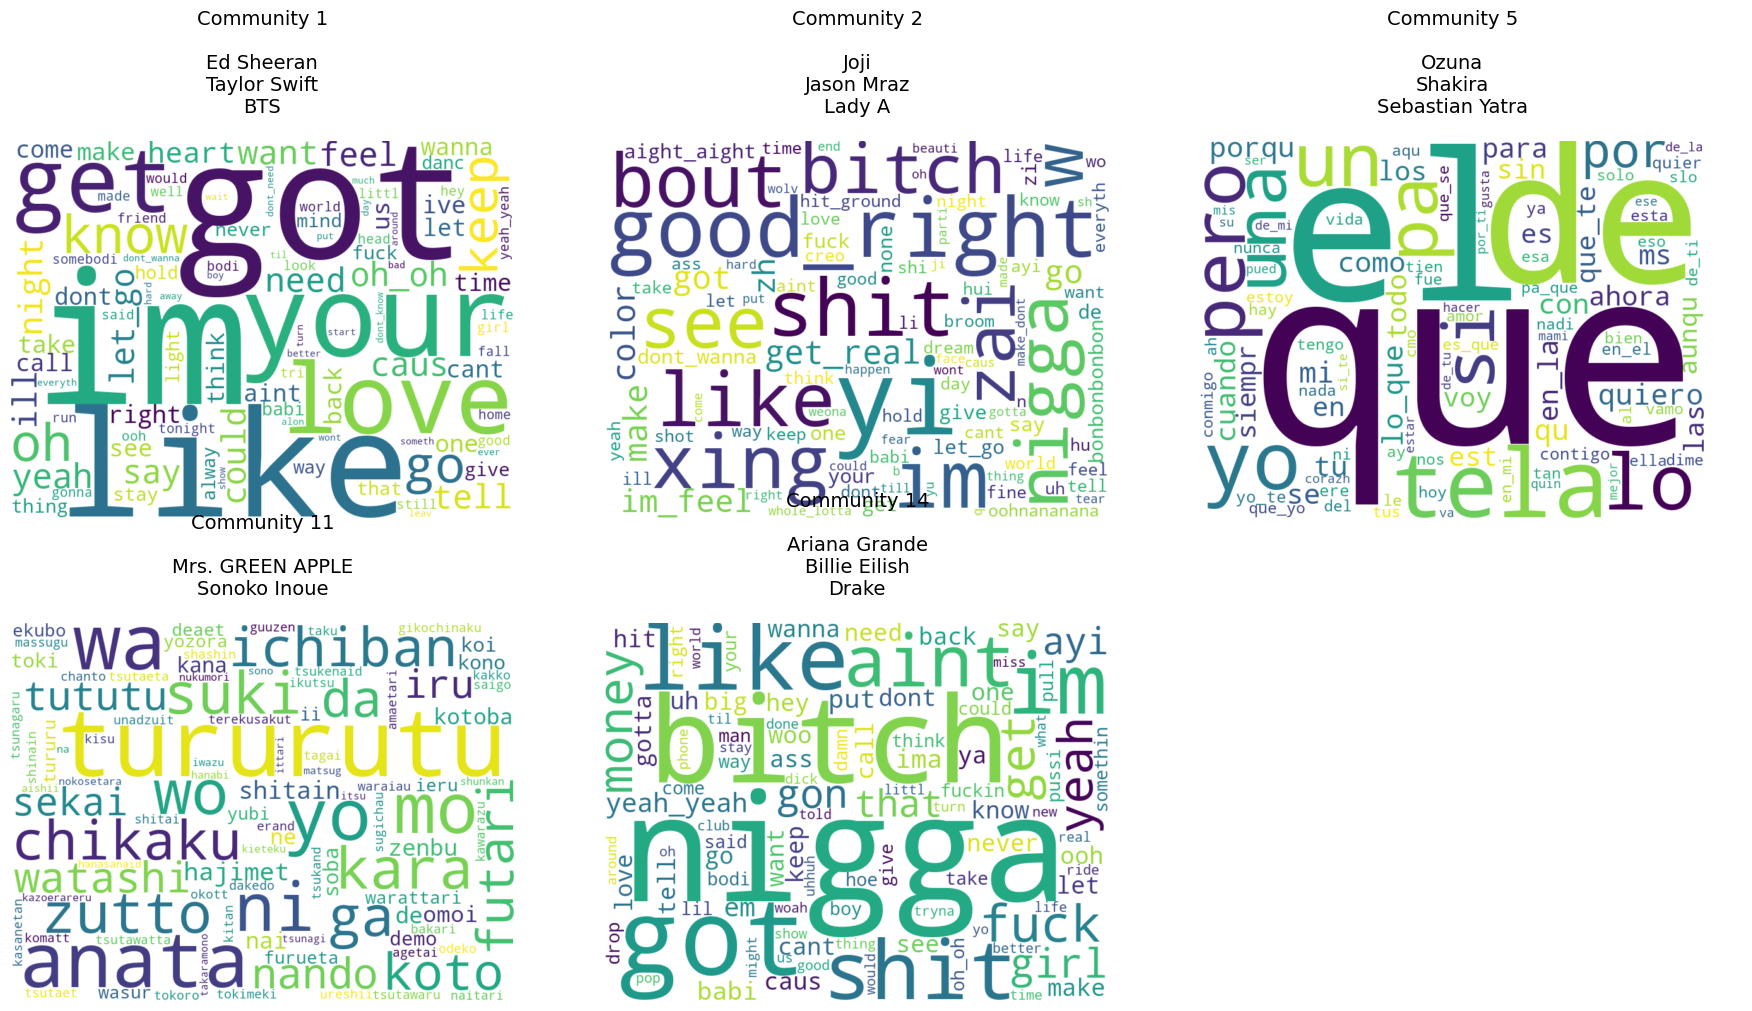

In [354]:
# Replace with your actual file path
pop_artists_filename = "pop_df.pkl"

with open(pop_artists_filename, "rb") as file:
    pop_artists_df : pd.DataFrame = pickle.load(file)
    
G_pop # Network used for analysis
pop_communities = community_louvain.best_partition(G_pop)

run_tf_idf_wordcloud_analysis(pop_artists_df, pop_communities, verbose=True)